# Learning Objective
Understand how self-supervised learning can utilize unlabeled data to make deep learning model generalize better.

# Task (30 points)
Implement a contrastive loss function (marked by #TODO in this notebook).

This contrastive loss function can be defined by yourself. You can consider using [SimCLR](https://arxiv.org/abs/2002.05709). You do not need to use [MoCo](https://arxiv.org/abs/1911.05722), as the implementation is slightly more complex. 

Training a model with a proper contrastive loss function should make sure if two random transformations of the same image should still be similar in their latent space, while transformations of different images should be very different. There are many ways to implement this function. You can test your own ideas first before searching GitHub source code for inspiration. 

In [6]:
# Load library
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import CIFAR10
from torchvision.models import resnet

# Recommend to use GPU as it will take quite some time if you only use cpu
use_gpu = True
if use_gpu and torch.cuda.is_available():
  device = torch.device("cuda") 

In [7]:
# This cell is to prepare data loaders

class CIFAR10Pair(CIFAR10):
    """This class is a subclass of torch.utils.data.Dataset; read its documentation if your have questions
    For each image in the CIFAR10 dataset, return two random transformations of itself
    """
    def __getitem__(self, index):
        img = self.data[index]
        img = Image.fromarray(img)

        if self.transform is not None:
            # im_1 and im_2 are two versions of img and should be similar to each other in latent space
            im_1 = self.transform(img)
            im_2 = self.transform(img)

        return im_1, im_2

batch_size = 512
# Random transform a image into two versions; used for contrastive learning
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(32),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomApply([transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)], p=0.8),
    transforms.RandomGrayscale(p=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])])
train_data = CIFAR10Pair(root='data', train=True, transform=train_transform, download=True)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=16, pin_memory=True, drop_last=True)

# No random transformation; used for conventional supervised learning
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])])

memory_data = CIFAR10(root='data', train=True, transform=test_transform)
memory_loader = DataLoader(memory_data, batch_size=batch_size, shuffle=False, num_workers=16, pin_memory=True)

test_data = CIFAR10(root='data', train=False, transform=test_transform)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=16, pin_memory=True)

Files already downloaded and verified


In [8]:
class FeatureExtractor(nn.Module):
  """
  Use ResNet18 as the feature extractor
  Comparing with ImageNet ResNet:
  (i) replaces conv1 with kernel=3, stride=1
  (ii) removes pool1
  """
  def __init__(self, feature_dim=128):
    super().__init__()
    net = resnet.resnet18(num_classes=feature_dim)
    self.net = []      
    for name, module in net.named_children():
      if name == 'conv1':
          module = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
      if isinstance(module, nn.MaxPool2d):
          continue
      if isinstance(module, nn.Linear):
          self.net.append(nn.Flatten(1))
      self.net.append(module)
    self.net = nn.Sequential(*self.net)

  def forward(self, x):
    x = self.net(x)
    return x

In [9]:
def train_model(feature_extractor, classifier, optimizer, num_epochs=100):
  """Train the model using only ~1% of labeled training data
  Args:
    feature_extractor: as defined above
    classifier: a simple nn.Linear layer
    optimizer: see code below for details
  """
  train_loss_history = []
  train_acc_history = []
  test_loss_history = []
  test_acc_history = []
  print_every = max(1, num_epochs // 20)
  for epoch in range(num_epochs):
    total_loss = 0
    total_acc = 0
    cnt = 0
    for i, (x_batch, y_batch) in enumerate(memory_loader):
      if i == 1: # Using roughly 1% of labeled training data because len(memory_loader) == 98
        break    # This training process only use the first batch, that is 1/98 entire training dataset.
      x_batch = x_batch.to(device)
      y_batch = y_batch.to(device)
      y_pred = classifier(feature_extractor(x_batch))
      loss = F.cross_entropy(y_pred, y_batch)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      total_loss += loss.item() * len(x_batch)
      total_acc += (y_pred.argmax(1) == y_batch).float().sum().item()
      cnt += len(x_batch)
    train_loss_history.append(total_loss / cnt)
    train_acc_history.append(total_acc / cnt)
    with torch.no_grad():
      total_loss = 0
      total_acc = 0
      for x_batch, y_batch in test_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        y_pred = classifier(feature_extractor(x_batch))
        loss = F.cross_entropy(y_pred, y_batch)
        total_loss += loss.item() * len(x_batch)
        total_acc += (y_pred.argmax(1) == y_batch).float().sum().item()
      test_loss_history.append(total_loss / len(test_loader.dataset))
      test_acc_history.append(total_acc / len(test_loader.dataset))
    if epoch % print_every == 0:
      print(f'Epoch {epoch}: train_loss={train_loss_history[-1]:.2f}, train_acc={train_acc_history[-1]:.2f}, '
      f'test_loss={test_loss_history[-1]:.2f}, test_acc={test_acc_history[-1]:.2f}')
  plt.plot(train_loss_history, 'ro--', label='train_loss')
  plt.plot(test_loss_history, 'go--', label='test_loss')
  plt.legend()
  plt.show()

  plt.plot(train_acc_history, 'ro--', label='train_acc')
  plt.plot(test_acc_history, 'go--', label='test_acc')
  plt.legend()
  plt.show()

Epoch 0: train_loss=2.36, train_acc=0.10, test_loss=6.73, test_acc=0.10
Epoch 5: train_loss=4.10, train_acc=0.13, test_loss=3.93, test_acc=0.11
Epoch 10: train_loss=2.84, train_acc=0.16, test_loss=3.12, test_acc=0.12
Epoch 15: train_loss=2.40, train_acc=0.20, test_loss=2.74, test_acc=0.14
Epoch 20: train_loss=2.30, train_acc=0.20, test_loss=2.69, test_acc=0.19
Epoch 25: train_loss=2.11, train_acc=0.24, test_loss=2.35, test_acc=0.20
Epoch 30: train_loss=1.89, train_acc=0.28, test_loss=2.21, test_acc=0.22
Epoch 35: train_loss=1.70, train_acc=0.35, test_loss=2.23, test_acc=0.25
Epoch 40: train_loss=1.65, train_acc=0.35, test_loss=2.14, test_acc=0.25
Epoch 45: train_loss=1.51, train_acc=0.44, test_loss=2.13, test_acc=0.28
Epoch 50: train_loss=1.40, train_acc=0.42, test_loss=2.39, test_acc=0.28
Epoch 55: train_loss=1.23, train_acc=0.51, test_loss=2.37, test_acc=0.30
Epoch 60: train_loss=1.15, train_acc=0.56, test_loss=2.49, test_acc=0.30
Epoch 65: train_loss=0.84, train_acc=0.69, test_loss=

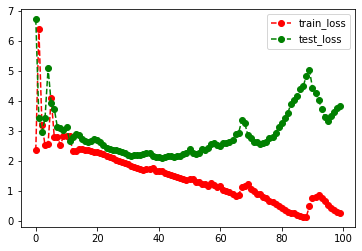

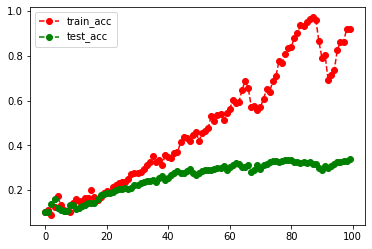

In [5]:
# Without self-supeversied learning, model does not generalize well. The test accuray is less than 30%
feature_dim = 256
num_classes = 10
feature_extractor = FeatureExtractor(feature_dim).to(device)
classifier = nn.Linear(feature_dim, num_classes).to(device)
optimizer = torch.optim.Adam(list(classifier.parameters()) + list(feature_extractor.parameters()), 
                            lr=5e-3, weight_decay=1e-4)
train_model(feature_extractor, classifier, optimizer)

In [15]:
##TODO
# This is what you need to implement
def contrast_loss(feature_extractor, x0, x1):
  """Given a feature extractor that transforms a batch of images to their latent representations, 
  Compute the contrastive loss

  Refer to the next cell: x0 and x1 are a batch of transformed images from train_loader
  Suppose batch_size = 512, then both x0 and x1 have shape (512, 3, 32, 32);
  feature_extractor(x0) and feature_extractor(x1) with both return a matrix of shape (batch_size, feature_dim)
  
  x0[i], x1[i] (i=0,1,2,3...,511) are two random transformations of the i th image; 
  therefore they should be similar in the latent space (i.e., the output of feature_extractor)

  In contrast, x0[i], x1[j] (i != j) should be different
  
  """
  y0 = feature_extractor(x0)
  y1 = feature_extractor(x1)
  #########################################TODO##########################################################
  ## Write your code here; it doesn't need to be too complex; the sample solution only has two lines, but that's just one of many solutions
  ## As long as you can significantly increase test accuracy using self-supervised learning, it means your implmentation of this loss function is working
  #torch.cuda.empty_cache()

  batch_size = y0.shape[0]
  z_i = F.normalize(y0, p=2, dim=1)
  z_j = F.normalize(y1, p=2, dim=1)

  representations = torch.cat([z_i, z_j], dim=0)
  similarity_matrix =  F.cosine_similarity(representations.unsqueeze(1), representations.unsqueeze(0), dim=2)


  sim_ij = torch.diag(similarity_matrix, batch_size)
  sim_ji = torch.diag(similarity_matrix, -batch_size)

  positives = torch.cat([sim_ij, sim_ji], dim=0)

  nominator = torch.exp(positives / 0.5) #temperature is 0.5

  mask = (~torch.eye(batch_size * 2, batch_size * 2, dtype=bool)).float()

  #mask.to(device)

  denominator = mask.to(similarity_matrix.device) * torch.exp(similarity_matrix / 0.5)

  all_losses = -torch.log(nominator / torch.sum(denominator, dim=1))
  loss = torch.sum(all_losses) / (2 * batch_size)
 


  #######################################################################################################
  return loss

Epoch 0: train_loss=6.19
Epoch 1: train_loss=5.89
Epoch 2: train_loss=5.79
Epoch 3: train_loss=5.72
Epoch 4: train_loss=5.68
Epoch 5: train_loss=5.64
Epoch 6: train_loss=5.61
Epoch 7: train_loss=5.59
Epoch 8: train_loss=5.57
Epoch 9: train_loss=5.57
Epoch 10: train_loss=5.55
Epoch 11: train_loss=5.54
Epoch 12: train_loss=5.53
Epoch 13: train_loss=5.52
Epoch 14: train_loss=5.52
Epoch 15: train_loss=5.51
Epoch 16: train_loss=5.50
Epoch 17: train_loss=5.50
Epoch 18: train_loss=5.49
Epoch 19: train_loss=5.48


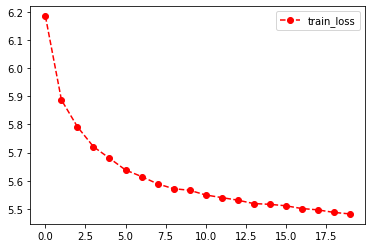

In [16]:
# With contrastive loss defined above, you train perferm self-supervised learning without using the actual labels in the training set
torch.cuda.empty_cache()
feature_dim = 256
feature_extractor = FeatureExtractor(feature_dim).to(device)
optimizer = torch.optim.Adam(feature_extractor.parameters(), lr=1e-3)
train_loss_history = []
num_epochs = 20
print_every = max(1, num_epochs // 20)
for epoch in range(num_epochs):
  total_loss = 0
  for x0, x1 in train_loader:
    x0 = x0.to(device)
    x1 = x1.to(device)
    loss = contrast_loss(feature_extractor, x0, x1)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    total_loss += loss.item() * len(x0)
  train_loss_history.append(total_loss / len(train_loader.dataset))
  if epoch % print_every == 0:
    print(f'Epoch {epoch}: train_loss={train_loss_history[-1]:.2f}')
plt.plot(train_loss_history, 'ro--', label='train_loss')
plt.legend()
plt.show()

Epoch 0: train_loss=3.63, train_acc=0.06, test_loss=2.10, test_acc=0.29
Epoch 5: train_loss=1.01, train_acc=0.65, test_loss=1.35, test_acc=0.57
Epoch 10: train_loss=0.97, train_acc=0.67, test_loss=1.50, test_acc=0.58
Epoch 15: train_loss=0.92, train_acc=0.69, test_loss=1.52, test_acc=0.58
Epoch 20: train_loss=0.87, train_acc=0.72, test_loss=1.55, test_acc=0.57
Epoch 25: train_loss=0.84, train_acc=0.71, test_loss=1.51, test_acc=0.58
Epoch 30: train_loss=0.81, train_acc=0.71, test_loss=1.48, test_acc=0.58
Epoch 35: train_loss=0.79, train_acc=0.71, test_loss=1.47, test_acc=0.58
Epoch 40: train_loss=0.77, train_acc=0.72, test_loss=1.45, test_acc=0.58
Epoch 45: train_loss=0.76, train_acc=0.73, test_loss=1.44, test_acc=0.57
Epoch 50: train_loss=0.75, train_acc=0.73, test_loss=1.41, test_acc=0.58
Epoch 55: train_loss=0.75, train_acc=0.72, test_loss=1.38, test_acc=0.58
Epoch 60: train_loss=0.74, train_acc=0.72, test_loss=1.37, test_acc=0.58
Epoch 65: train_loss=0.73, train_acc=0.73, test_loss=

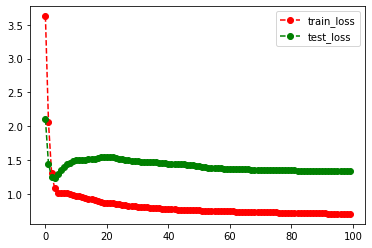

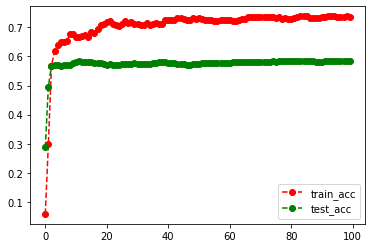

In [18]:
# Freeze the parameters of the feature extractor after self-supervised learning
# Only train the last linear layer
# You should find out the model generalize much better than that without self-supervised learning
# Note here model generalization refers to the test accuracy; 
# You can compare the test accuracy here and the previous one without self-supervised learning
num_classes = 10
feature_extractor.requires_grad_(False)
classifier = nn.Linear(feature_dim, num_classes).to(device)
optimizer = torch.optim.Adam(classifier.parameters(), lr=5e-3, weight_decay=1e-4)
train_model(feature_extractor, classifier, optimizer)